In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib

In [20]:
DX = [0, 1, 1, 1, 0, -1, -1, -1]
DY = [-1, -1, 0, 1, 1, 1, 0, -1]

def generate_neighbour(img, y, x):
    h, w = img.shape
    p2 = img[y-1][x] if y > 0 else 0
    p3 = img[y-1][x+1] if y > 0 and x < w-1 else 0
    p4 = img[y][x+1] if x < w-1 else 0
    p5 = img[y+1][x+1] if y < h-1 and x < w-1 else 0
    p6 = img[y+1][x] if y < h-1 else 0
    p7 = img[y+1][x-1] if y < h-1 and x > 0 else 0
    p8 = img[y][x-1] if x > 0 else 0
    p9 = img[y-1][x-1] if y > 0 and x > 0 else 0
    return [p2,p3,p4,p5,p6,p7,p8,p9]

def check_delete(image, y, x):
    if image[y][x] == 0:
        return False
    ps = generate_neighbour(image, y, x)
    np = len(list(filter(lambda x : x != 0, ps)))
    sp = 0
    for i in range(len(ps)):
        j = (i + 1) % len(ps)
        sp += 1 if ps[i] != 0 and ps[j] == 0 else 0
    ret = (2 <= np) and (np <= 6) and (sp == 1) and (ps[2] == 0 or ps[4] == 0 or (ps[0] == 0 and ps[6] == 0))
    return ret

def check_delete_2(image, y, x):
    if image[y][x] == 0:
        return False
    ps = generate_neighbour(image, y, x)
    np = len(list(filter(lambda x : x != 0, ps)))
    sp = 0
    for i in range(len(ps)):
        j = (i + 1) % len(ps)
        sp += 1 if ps[i] != 0 and ps[j] == 0 else 0
    ret = (2 <= np) and (np <= 6) and (sp == 1) and (ps[0] == 0 or ps[6] == 0 or (ps[2] == 0 and ps[4] == 0))
    return ret

def thinning(img):
    height, width = img.shape
    img = img.copy()
    change = True
    while change:
        must_delete = []
        change = False
        for y in range(height):
            for x in range(width):
                if check_delete(img, y, x):
                    change = True
                    must_delete += [(x,y)]
        for v in must_delete:
            img[v[1]][v[0]] = 0

        must_delete = []
        for y in range(height):
            for x in range(width):
                if check_delete_2(img, y, x):
                    change = True
                    must_delete += [(x,y)]
        for v in must_delete:
            img[v[1]][v[0]] = 0
        must_delete = []
    return img

def is_corner(img, y, x):
    neighbours = generate_neighbour(img, y, x)
    sp = 0
    for i in range(len(neighbours)):
        j = (i + 1) % len(neighbours)
        sp += 1 if neighbours[i] != 0 and neighbours[j] == 0 else 0
    return img[y][x] != 0 and sp == 1

def is_intersection(img, y, x):
    neighbours = generate_neighbour(img, y, x)
    n = sum(neighbours)
    sp = 0
    for i in range(len(neighbours)):
        j = (i + 1) % len(neighbours)
        sp += 1 if neighbours[i] != 0 and neighbours[j] == 0 else 0
    return img[y][x] != 0 and n > 2 and sp > 2

def get_corner_and_intersection(img, upper_bound=(0,0), lower_bound=(100, 100)):
    img = img.copy()
    visited = np.zeros(img.shape)
    h, w = img.shape
    res_corners = []
    res_intersections = []
    for y in range(upper_bound[1], lower_bound[1]):
        for x in range(upper_bound[0], lower_bound[0]):
            if img[y][x] != 0:
                corners = []
                intersections = []
                stack = [(x,y)]
                perimeter = 0
                while len(stack) > 0:
                    cx, cy = stack.pop()
                    if visited[cy][cx] == 1:
                        continue
                    perimeter += 1
                    visited[cy][cx] = 1
                    if is_corner(img, cy, cx):
                        corners.append((cx, cy))
                    if is_intersection(img, cy, cx):
                        intersections.append((cx, cy))
                    for ddx, ddy in zip(DX, DY):
                        nx = cx + ddx
                        ny = cy + ddy
                        if nx >= 0 and nx < w and ny >= 0 and ny < h and visited[ny][nx] == 0 and img[ny][nx] != 0:
                            stack.append((nx, ny))
                # remove some corners
                real_corners = []
                for i, corner in enumerate(corners):
                    real_corners += [corner]
                    for intersect in intersections:
                        # there is intersection point near this corner point
                        if np.linalg.norm(np.array(corner)-np.array(intersect)) < perimeter * 0.05:
                            real_corners.pop()
                            # remove corner until the corner are gone
                            current_corner = corner
                            s = 1
                            while s == 1:
                                img[current_corner[1]][current_corner[0]] = 0
                                ns = generate_neighbour(img, current_corner[1], current_corner[0])
                                s = 0
                                for direction_i, val in enumerate(ns):
                                    s += val
                                    if val > 0:
                                        current_corner = (
                                            current_corner[0] + DX[direction_i],
                                            current_corner[1] + DY[direction_i]
                                        )
                            break
                # recalculate intersections
                real_intersections = []
                for intersection in intersections:
                    if is_intersection(img, intersection[1], intersection[0]):
                        real_intersections += [intersection]
                if perimeter > 20:
                    res_corners += real_corners
                    res_intersections += real_intersections
                
    return res_corners, res_intersections

def get_bounds(img):
    img = img.copy()
    h, w = img.shape
    upper_bounds = []
    lower_bounds = []
    for x in range(w):
        for y in range(h):
            if img[y][x] > 0:
                upper_bound = (x, y)
                lower_bound = (x + 1, y + 1)
                st = [(x, y)]
                while len(st) > 0:
                    cx, cy = st.pop()
                    if img[cy][cx] == 0:
                        continue
                    img[cy][cx] = 0
                    upper_bound = (min(upper_bound[0], cx), min(upper_bound[1], cy))
                    lower_bound = (max(lower_bound[0], cx + 1), max(lower_bound[1], cy + 1))
                    for dx, dy in zip(DX, DY):
                        nx, ny = cx + dx, cy + dy
                        if nx >= 0 and ny >= 0 and nx < w and ny < h and img[ny][nx] > 0:
                            st.append((nx, ny))
                upper_bounds.append(upper_bound)
                lower_bounds.append(lower_bound)
                
    ub_result = []
    lb_result = []
    join_with = []
    for i in range(len(upper_bounds)):
        join_with.append([i])
        for j in range(i + 1, len(upper_bounds)):
            # check whether i and j is an object
            dist_x = min(abs(upper_bounds[i][0] - lower_bounds[j][0]), abs(upper_bounds[j][0] - lower_bounds[i][0]))
            if upper_bounds[i][0] >= upper_bounds[j][0] and upper_bounds[i][0] < lower_bounds[j][0]:
                dist_x = 0
            if lower_bounds[i][0] - 1 >= upper_bounds[j][0] and lower_bounds[i][0] <= lower_bounds[j][0]:
                dist_x = 0
            if upper_bounds[j][0] >= upper_bounds[i][0] and upper_bounds[j][0] < lower_bounds[i][0]:
                dist_x = 0
            if lower_bounds[j][0] - 1 >= upper_bounds[i][0] and lower_bounds[j][0] <= lower_bounds[i][0]:
                dist_x = 0
                
            dist_y = min(abs(upper_bounds[i][1] - lower_bounds[j][1]), abs(upper_bounds[j][1] - lower_bounds[i][1]))
            if upper_bounds[i][1] >= upper_bounds[j][1] and upper_bounds[i][1] < lower_bounds[j][1]:
                dist_y = 0
            if lower_bounds[i][1] - 1 >= upper_bounds[j][1] and lower_bounds[i][1] <= lower_bounds[j][1]:
                dist_y = 0
            if upper_bounds[j][1] >= upper_bounds[i][1] and upper_bounds[j][1] < lower_bounds[i][1]:
                dist_y = 0
            if lower_bounds[j][1] - 1 >= upper_bounds[i][1] and lower_bounds[j][1] <= lower_bounds[i][1]:
                dist_y = 0
                
            if dist_x < 1 and dist_y < 35:
                join_with[i].append(j)
                
    skip = []
    for i in range(len(join_with)):
        if i in skip:
            continue
        components = []
        st = join_with[i]
        while len(st) > 0:
            j = st.pop()
            if j not in components:
                components.append(j)
            for c in join_with[j]:
                if c not in components:
                    st.append(c)
        
        ub_result.append((
            min([upper_bounds[k][0] for k in components]),
            min([upper_bounds[k][1] for k in components])
        ))
        lb_result.append((
            max([lower_bounds[k][0] for k in components]),
            max([lower_bounds[k][1] for k in components])
        ))
        
        skip += components
    
    return ub_result, lb_result

def get_feature(img, upper_bound, lower_bound):
    corner, intersection = get_corner_and_intersection(img, upper_bound, lower_bound)
    
    corner_count = np.zeros(9)
    intersect_count = np.zeros(9)
    tile_density = np.zeros(9)
    
    bound_width = lower_bound[0] - upper_bound[0]
    bound_height = lower_bound[1] - upper_bound[1]
    grid_x_size = bound_width / 3
    grid_y_size = bound_height / 3
    x1, x2 = upper_bound[0] + grid_x_size, upper_bound[0] + grid_x_size * 2
    y1, y2 = upper_bound[1] + grid_y_size, upper_bound[1] + grid_y_size * 2
    
    def get_index(point):
        if point[0] < x1:
            j = 0
        elif point[0] < x2:
            j = 1
        else:
            j = 2
        if point[1] < y1:
            i = 0
        elif point[1] < y2:
            i = 1
        else:
            i = 2
        return 3 * i + j
    
    for c in corner:
        if c[0] < upper_bound[0] or c[1] < upper_bound[1] or c[0] >= lower_bound[0] or c[1] >= lower_bound[1]:
            continue
        corner_count[get_index(c)] += 1
        
    for c in intersection:
        if c[0] < upper_bound[0] or c[1] < upper_bound[1] or c[0] >= lower_bound[0] or c[1] >= lower_bound[1]:
            continue
        intersect_count[get_index(c)] += 1
        
    for x in range(upper_bound[0], lower_bound[0]):
        for y in range(upper_bound[1], lower_bound[1]):
            tile_density[get_index((x, y))] += img[y][x]
    for i in range(9):
        tile_density[i] /= (lower_bound[1] - upper_bound[1]) * (lower_bound[0] - upper_bound[0])
            
    features = []
    
    def expand(arr):
        result = []
        for h in range(1, 4):
            for w in range(1, 4):
                for y in range(3-h+1):
                    for x in range(3-w+1):
                        s = 0
                        for dx in range(w):
                            for dy in range(h):
                                s += arr[(y + dy) * 3 + (x + dx)]
                        result.append(s)
        return result
    
    features += expand(corner_count)
    features += expand(intersect_count)
    features += expand(tile_density)
    features += [(lower_bound[1] - upper_bound[1]) / (lower_bound[0] - upper_bound[0])]
            
    return features

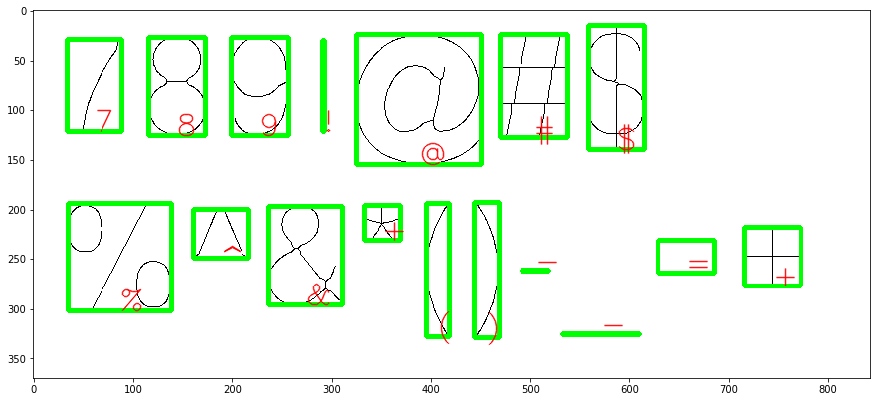

In [21]:
img = cv2.imread('test_2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGRA2GRAY)
_, img = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
img = cv2.bitwise_not(img)
img = cv2.erode(img, np.ones((3,3)), iterations=1)
img = thinning(img)

clf = joblib.load('model.joblib') 

upper_bounds, lower_bounds = get_bounds(img)
features = []
for ub, lb in zip(upper_bounds, lower_bounds):
    feature = get_feature(img, ub, lb)
    features.append(feature)
    
prediction = clf.predict(features)

img = cv2.bitwise_not(img)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
i = 0
for ub, lb in zip(upper_bounds, lower_bounds):
    cv2.rectangle(img,ub,lb,(0,255,0),3)
    font = cv2.FONT_HERSHEY_SIMPLEX
    pred = prediction[i]
    i += 1
    cv2.putText(img, chr(int(pred)),((ub[0] + lb[0]) // 2, lb[1]), font, 1, (255,0,0), 1, cv2.LINE_AA)

plt.figure(figsize=(15,15))
plt.imshow(img)
plt.show()